# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

* In this example, you'll be creating a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator. To accomplish this, you'll be utilizing a [simple Python library](https://pypi.python.org/pypi/citipy), the [OpenWeatherMap API](https://openweathermap.org/api), and a little common sense to create a representative model of weather across world cities.

Your first requirement is to create a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

After each plot add a sentence or too explaining what the code is and analyzing.

Your second requirement is to run linear regression on each relationship, only this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude):

* Northern Hemisphere - Temperature (F) vs. Latitude
* Southern Hemisphere - Temperature (F) vs. Latitude
* Northern Hemisphere - Humidity (%) vs. Latitude
* Southern Hemisphere - Humidity (%) vs. Latitude
* Northern Hemisphere - Cloudiness (%) vs. Latitude
* Southern Hemisphere - Cloudiness (%) vs. Latitude
* Northern Hemisphere - Wind Speed (mph) vs. Latitude
* Southern Hemisphere - Wind Speed (mph) vs. Latitude

In [81]:

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime


# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Import API key
from api_keys import weather_api_key
from api_keys import g_key

## Generate Cities List

In [82]:
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# List for holding lat_lngs and cities
lat_lngs = []
cities = []
countries = []

# Create a set of random lat and lng combinations and zip into a list of tuples
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination using the Citypy package to return a unique city and country code
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    country = citipy.nearest_city(lat_lng[0], lat_lng[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Combine the two lists into a list of tuples using the zip function
city_country = zip(cities,countries)

# Print the city count to confirm sufficient count ( Greater than 500 )
print(len(cities))

617


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [62]:
# Save config information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# set up lists to hold reponse info
city_id = []
city_name = []
country = []
latitude = []
longitude = []
weather_date = []
temp = []
humidity = []
cloudiness = []
wind_speed = []

# Open file to write results of API calls - success or not into a txt file, as well as all data pulled into a csv
myprintlog = open('weatherAPI_printlog.txt', 'w')
myAPIdata = open('weatherAPI_data.csv', 'w')
# Print header that it's begining data retrieval
print('------------------------')
print('Beginning Data Retrieval')
print('------------------------')

# Write header line for csv file
myAPIdata.write("city_id,city_name,country,latitude,longitude,weather_date,temp,humidity,cloudiness,wind_speed\n")

# Loop through the list of tuples of cities,country codes and perform a request for data on each
for city,country_code in city_country:
    query_url = f"{url}appid={weather_api_key}&q={city},{country_code}&units={units}"
    response = requests.get(query_url).json()

    # Try to grab the temp,humidity,cloudiness and wind speed if they are available in the Weather API
    # if the city is not found on the WeatherAPI site then the "except" will catch the error and the loop will
    # continue to go through the rest of the city,country_codes in the city_country list
    try:
        # Create variables for each response item and format to desired datatype
        cityID = int(response['id'])
        cityName = response['name']
        countryCode = response['sys']['country']
        lat_val = response['coord']['lat']
        lon_val = response['coord']['lon']
        weatherDate = (datetime.fromtimestamp(response['dt'])).strftime('%m/%d/%y')
        temperature = response['main']['temp']
        humidity_val = response['main']['humidity']
        cloudiness_val = response['clouds']['all']
        windSpeed = response['wind']['speed']
        
        # Append retreived values to lists above using the variables created above
        city_id.append(cityID)
        city_name.append(cityName)
        country.append(countryCode)
        latitude.append(lat_val)
        longitude.append(lon_val)
        weather_date.append(weatherDate)
        temp.append(temperature)
        humidity.append(humidity_val)
        cloudiness.append(cloudiness_val)
        wind_speed.append(windSpeed)
        
        # Output line to terminal to mark progress and store it to a print log text file
        print(f"{cityName} with city ID:{cityID} was found in the Weathermap API\n")
        myprintlog.write(f"{cityName} with city ID:{cityID} was found in the Weathermap API\n")
        
        # Output all retreived values to a csv file
        myAPIdata.write(f"{cityID},{cityName},{countryCode},{lat_val},{lon_val},{weatherDate},\
            {temperature},{humidity_val},{cloudiness_val},{windSpeed}\n")
        
    # Handle exceptions for a city that is not available in the Weather API
    except:
        
        print(f"{city},{country_code} was not found in the Weathermap API\n")
        myprintlog.write(f"{city},{country_code} was not found in the Weathermap API\n")
        
        # Append null values so lists are all the same length (later we will remove nulls from dataframe)
        city_id.append(None)
        city_name.append(None)
        country.append(None)
        latitude.append(None)
        longitude.append(None)
        weather_date.append(None)
        temp.append(None)
        humidity.append(None)
        cloudiness.append(None)
        wind_speed.append(None)
        pass
    
# Close the file handle after completion of the loop
myprintlog.close()
myAPIdata.close()
print('-------------------------')
print('Data Retrieval Complete')
print('-------------------------')

------------------------
Beginning Data Retrieval
------------------------
Albany with city ID:2077963 was found in the Weathermap API

Margate with city ID:978895 was found in the Weathermap API

Bonthe with city ID:2409914 was found in the Weathermap API

Port Alfred with city ID:964432 was found in the Weathermap API

Avarua with city ID:4035715 was found in the Weathermap API

Jamestown with city ID:3370903 was found in the Weathermap API

Diego de Almagro with city ID:3892454 was found in the Weathermap API

Tsimmerbude with city ID:485660 was found in the Weathermap API

amderma,ru was not found in the Weathermap API

tabiauea,ki was not found in the Weathermap API

Hermanus with city ID:3366880 was found in the Weathermap API

Patacamaya with city ID:3908339 was found in the Weathermap API

Lebu with city ID:3883457 was found in the Weathermap API

Tessalit with city ID:2449893 was found in the Weathermap API

Pevek with city ID:2122090 was found in the Weathermap API

Ribeira G

Brae with city ID:2654970 was found in the Weathermap API

Kawalu with city ID:1640902 was found in the Weathermap API

Trinidad with city ID:3534915 was found in the Weathermap API

Talnakh with city ID:1490256 was found in the Weathermap API

Armeniş with city ID:686137 was found in the Weathermap API

Lüderitz with city ID:3355672 was found in the Weathermap API

Moerai with city ID:4034188 was found in the Weathermap API

Huarmey with city ID:3939168 was found in the Weathermap API

Kloulklubed with city ID:7671223 was found in the Weathermap API

Mahébourg with city ID:934322 was found in the Weathermap API

Beloha with city ID:1067565 was found in the Weathermap API

Bengkulu with city ID:1649150 was found in the Weathermap API

Lorengau with city ID:2092164 was found in the Weathermap API

Tura with city ID:2014833 was found in the Weathermap API

Isangel with city ID:2136825 was found in the Weathermap API

New Norfolk with city ID:2155415 was found in the Weathermap API

Rolli

Mill Valley with city ID:5373121 was found in the Weathermap API

Coruripe with city ID:3465329 was found in the Weathermap API

Celestún with city ID:3531368 was found in the Weathermap API

Kachug with city ID:2023333 was found in the Weathermap API

Skjervøy with city ID:777682 was found in the Weathermap API

Moree with city ID:2156927 was found in the Weathermap API

São José da Coroa Grande with city ID:3388456 was found in the Weathermap API

Nanortalik with city ID:3421765 was found in the Weathermap API

mys shmidta,ru was not found in the Weathermap API

Inongo with city ID:2315417 was found in the Weathermap API

Nyergesújfalu with city ID:3047282 was found in the Weathermap API

Vostok with city ID:2013279 was found in the Weathermap API

Grand Gaube with city ID:934479 was found in the Weathermap API

El Roble with city ID:3683180 was found in the Weathermap API

Ipilan with city ID:1710590 was found in the Weathermap API

Hambantota with city ID:1244926 was found in the W

grand river south east,mu was not found in the Weathermap API

Haines Junction with city ID:5969025 was found in the Weathermap API

Beïnamar with city ID:2435708 was found in the Weathermap API

Jhelum with city ID:1175864 was found in the Weathermap API

Houma with city ID:4328010 was found in the Weathermap API

Bezopasnoye with city ID:576519 was found in the Weathermap API

bolungarvik,is was not found in the Weathermap API

yaan,cn was not found in the Weathermap API

Andenes with city ID:3163146 was found in the Weathermap API

Douglas with city ID:5067114 was found in the Weathermap API

Lárdos with city ID:408689 was found in the Weathermap API

Lázaro Cárdenas with city ID:4026082 was found in the Weathermap API

dzhusaly,kz was not found in the Weathermap API

Khuzhir with city ID:2022143 was found in the Weathermap API

Ola with city ID:2122574 was found in the Weathermap API

sentyabrskiy,ru was not found in the Weathermap API

marzuq,ly was not found in the Weathermap API

Vestmannaeyjar with city ID:3412093 was found in the Weathermap API

Osoyoos with city ID:6094665 was found in the Weathermap API

Te Anau with city ID:2181625 was found in the Weathermap API

Sioux Lookout with city ID:6148373 was found in the Weathermap API

Nové Město na Moravě with city ID:3069465 was found in the Weathermap API

Cap-aux-Meules with city ID:5915327 was found in the Weathermap API

Bereket with city ID:161974 was found in the Weathermap API

Bathsheba with city ID:3374083 was found in the Weathermap API

Najrān with city ID:103630 was found in the Weathermap API

Makakilo City with city ID:5850554 was found in the Weathermap API

Saqqez with city ID:117392 was found in the Weathermap API

Bowen with city ID:2174444 was found in the Weathermap API

Chāndbāli with city ID:1274761 was found in the Weathermap API

Mookane with city ID:933290 was found in the Weathermap API

Matagami with city ID:6067747 was found in the Weathermap API

sogdiondon,ru was not found in the

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [63]:

# create a dictionary from the lists that we created above
weather_dict = {
    "City": city_name,
    "Lat": latitude,
    "Lng": longitude,
    "Max Temp": temp,
    "Humidity": humidity,
    "Cloudiness": cloudiness,
    "Wind Speed": wind_speed,
    "Country": country,
    "Date": weather_date,
}

# Use the dictionary to create a dataframe named weather_data
weather_d = pd.DataFrame(weather_dict)
weather_d.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Albany,-35.02,117.89,41.00,86.0,60.0,4.70,AU,10/05/20
1,Margate,-30.86,30.37,69.84,86.0,100.0,20.33,ZA,10/05/20
2,Bonthe,7.53,-12.51,78.42,80.0,99.0,6.46,SL,10/05/20
3,Port Alfred,-33.59,26.89,64.89,85.0,29.0,8.59,ZA,10/05/20
4,Avarua,-21.21,-159.78,73.40,69.0,35.0,5.82,CK,10/05/20


In [64]:
 print(len(weather_d))

601


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [65]:
#  Get the indices of cities that have humidity over 100%.

humidity_over_100_ind = weather_d[weather_d["Humidity"] > 100].index


print(humidity_over_100_ind)

Int64Index([], dtype='int64')


In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

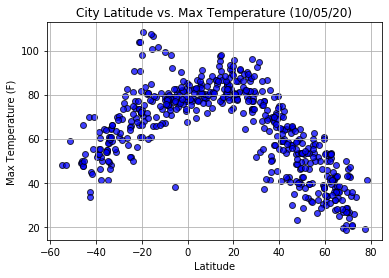

In [66]:
# Get the reporting date as today's date
reporting_date = pd.to_datetime('today').strftime('%m/%d/%y')

# Generate a scatter plot of Latitude versus Max Temperature 
plt.scatter(
    weather_d["Lat"],
    weather_d["Max Temp"],
    marker='o',
    facecolors='blue',
    edgecolors='black',
    alpha=.75)

# Assign title, x label, and y label for our chart
plt.title(f"City Latitude vs. Max Temperature (" + str(reporting_date) + ")")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.grid()
# Save the figure
plt.savefig("../Images/ScatterCityLatitudeMaxTemperature.png")

plt.show()

## Latitude vs. Humidity Plot

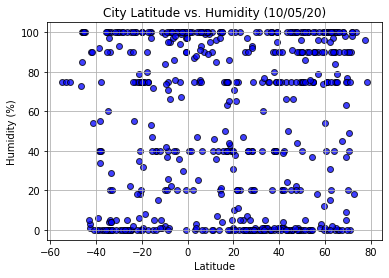

In [67]:
# Generate a scatter plot of Latitude versus Max Temperature 
plt.scatter(
   weather_d["Lat"],
    weather_d["Cloudiness"],
    marker='o',
    facecolors='blue',
    edgecolors='black',
    alpha=.75)

# Assign title, x label, and y label for our chart
plt.title(f"City Latitude vs. Humidity (" + str(reporting_date) + ")")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
# Save the figure
plt.savefig("../Images/ScatterCityLatitudeHumidity.png")

plt.show()

## Latitude vs. Cloudiness Plot

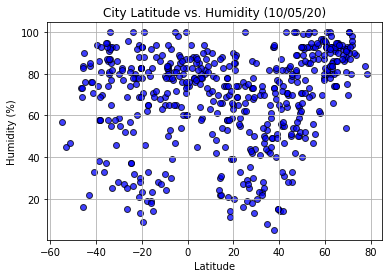

In [68]:
plt.scatter(
   weather_d["Lat"],
    weather_d["Humidity"],
    marker='o',
    facecolors='blue',
    edgecolors='black',
    alpha=.75)

# Assign title, x label, and y label for our chart
plt.title(f"City Latitude vs. Humidity (" + str(reporting_date) + ")")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
# Save the figure
plt.savefig("../Images/ScatterCityLatitudeHumidity.png")

plt.show()

## Latitude vs. Wind Speed Plot

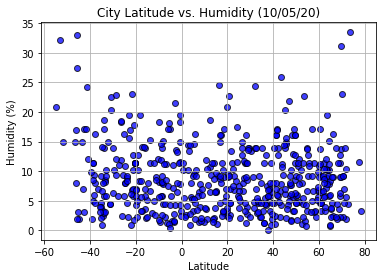

In [69]:
# Generate a scatter plot of Latitude versus Max Temperature 
plt.scatter(
   weather_d["Lat"],
    weather_d["Wind Speed"],
    marker='o',
    facecolors='blue',
    edgecolors='black',
    alpha=.75)

# Assign title, x label, and y label for our chart
plt.title(f"City Latitude vs. Humidity (" + str(reporting_date) + ")")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.grid()
# Save the figure
plt.savefig("../Images/ScatterCityLatitudeHumidity.png")

plt.show()

## Linear Regression

In [70]:

# get data frame ready to plotting
clean_city_data_north_df = weather_d[(weather_d["Lat"] >= 0)
                                              & (weather_d["Lat"] <= 90)]

# Diplay the data frame to begin plotting
clean_city_data_south_df =weather_d[(weather_d["Lat"] >= -90)
                                              & (weather_d["Lat"] <= 0)]


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.07103760898966206
The equation of the regression line is: y = 0.02x + 7.44


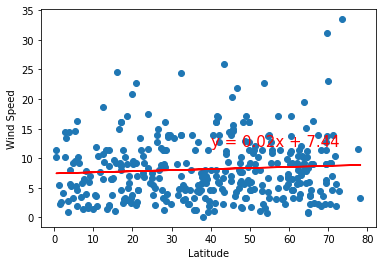

In [71]:
x_values = clean_city_data_north_df["Lat"]
y_values = clean_city_data_north_df["Wind Speed"]

# Assign linregress values
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (17,20), fontsize=15, color="red",
            xytext=(40, 12))

# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")

# Print r-value
print(f"The r-value is: {rvalue}")

# Print equation of the regression line
print(f"The equation of the regression line is: {line_eq}")

# Save the figure
plt.savefig("../Images/ScatterNHLatitudeWindSpeedRegression.png")

plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6674890949574364
The equation of the regression line is: y = 0.7x + 84.7


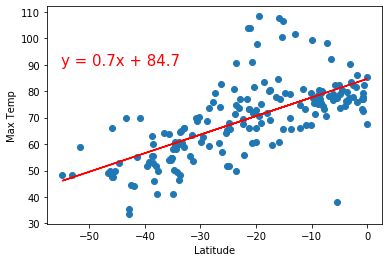

In [72]:
x_values = clean_city_data_south_df["Lat"]
y_values = clean_city_data_south_df["Max Temp"]

# Assign linregress values
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (-50,50), fontsize=15, color="red",
            xytext=(-55, 90))


# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Max Temp")

# Print r-value
print(f"The r-value is: {rvalue}")

# Print equation of the regression line
print(f"The equation of the regression line is: {line_eq}")

# Save the figure
plt.savefig("../Images/ScatterSHLatitudeMaxTempRegression.png")

plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.33551214963799064


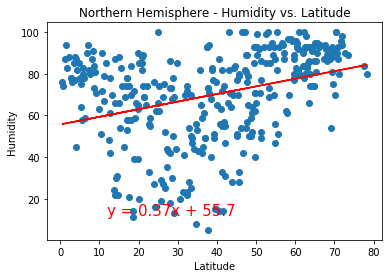

In [73]:
#  x_values, y_values

x_values = clean_city_data_north_df["Lat"]
y_values = clean_city_data_north_df["Humidity"]

# Assign linregress values
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (17,37), fontsize=15, color="red",
            xytext=(12, 12))

# Plot title
plt.title("Northern Hemisphere - Humidity vs. Latitude")

# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Humidity")

# Print r-value
print(f"The r-value is: {rvalue}")



# Save the figure
plt.savefig("../Images/ScatterNHLatitudeMaxTempRegression.png")

plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.05405509456261413
The equation of the regression line is: y = 0.09x + 69.94


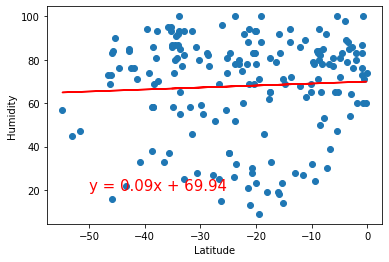

In [74]:
# Assign linregress values
x_values = clean_city_data_south_df["Lat"]
y_values = clean_city_data_south_df["Humidity"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (-50,50), fontsize=15, color="red",
            xytext=(-50, 20))


# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Humidity")

# Print r-value
print(f"The r-value is: {rvalue}")

# Print equation of the regression line
print(f"The equation of the regression line is: {line_eq}")

# Save the figure
plt.savefig("../Images/ScatterSHLatitudeHumidityRegression.png")

plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.11158088358031319
The equation of the regression line is: y = 0.22x + 44.3


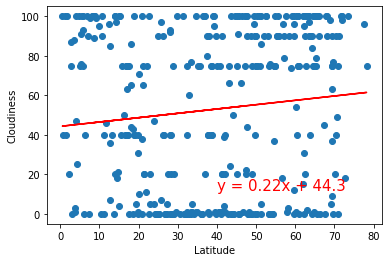

In [75]:
# Assign linregress values
x_values = clean_city_data_north_df["Lat"]
y_values = clean_city_data_north_df["Cloudiness"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (17,37), fontsize=15, color="red",
            xytext=(40, 12))



# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

# Print r-value
print(f"The r-value is: {rvalue}")

# Print equation of the regression line
print(f"The equation of the regression line is: {line_eq}")

# Save the figure
plt.savefig("../Images/ScatterNHLatitudeCloudinessRegression.png")

plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.14992522059329094
The equation of the regression line is: y = 0.44x + 64.65


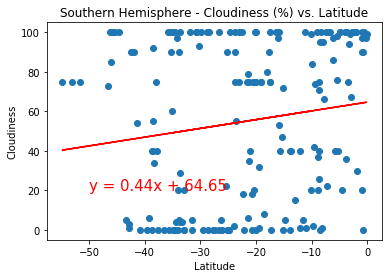

In [76]:

# Assign linregress values
x_values = clean_city_data_south_df["Lat"]
y_values = clean_city_data_south_df["Cloudiness"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (-50,50), fontsize=15, color="red",
            xytext=(-50, 20))

# Plot title
plt.title("Southern Hemisphere - Cloudiness (%) vs. Latitude")

# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

# Print r-value
print(f"The r-value is: {rvalue}")

# Print equation of the regression line
print(f"The equation of the regression line is: {line_eq}")

# Save the figure
plt.savefig("../Images/ScatterSHLatitudeCloudinessRegression.png")

plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.07103760898966206


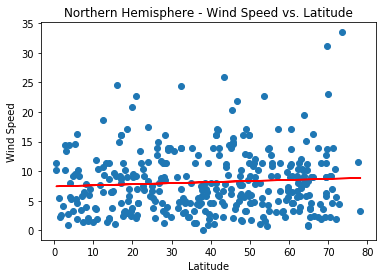

In [77]:
#  x_values, y_values

x_values = clean_city_data_north_df["Lat"]
y_values = clean_city_data_north_df["Wind Speed"]

# Assign linregress values
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (17,37), fontsize=15, color="red",
            xytext=(12, 12))

# Plot title
plt.title("Northern Hemisphere - Wind Speed vs. Latitude")

# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")

# Print r-value
print(f"The r-value is: {rvalue}")



# Save the figure
plt.savefig("../Images/ScatterNHLatitudeMaxTempRegression.png")

plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.19953009735022767
The equation of the regression line is: y = -0.09x + 7.45


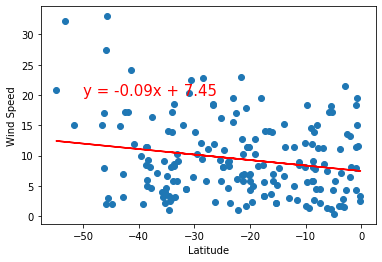

In [78]:
x_values = clean_city_data_south_df["Lat"]
y_values = clean_city_data_south_df["Wind Speed"]

# Assign linregress values
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

# Assign line equation values
line_eq = f"y = {str(round(slope,2))}x + {str(round(intercept,2))}"

# Plot scatter plot
plt.scatter(x_values, y_values)

# Plot regression line
plt.plot(x_values, regress_values, "r-")

# Annotate line equation
plt.annotate(line_eq, (-50,20), fontsize=15, color="red",
            xytext=(-50, 20))


# Plot x-label and y-label
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")

# Print r-value
print(f"The r-value is: {rvalue}")

# Print equation of the regression line
print(f"The equation of the regression line is: {line_eq}")

# Save the figure
plt.savefig("../Images/ScatterSHLatitudeWindSpeedRegression.png")

plt.show()